# **Predicting COVID-19 Transmission Risk**

**Introduction:**


We plan to help out Billy, who has recently lost his job due to COVID-19 and is trying to find a job in another country. He prefers to move to a country that will be safer, with fewer new COVID cases. 

We aim to help Billy answer the question: “How safe is it to move to country X?” by predicting the number of new_cases_per_million through KNN-Regression. A lower number indicates a safer country with lower transmission risk. We will use a categorical variable “risk level”, that we created ourselves, to more easily interpret the numerical output of our prediction. 

We will use worldwide data collected over the past few months of the pandemic ([Ritchie 2020](https://ourworldindata.org/coronavirus-source-data)). This dataset contains many variables, but we will use population density, stringency index (a composite measure of government COVID-19 response), GDP per capita (economic output per person), hospital beds per thousand, and life expectancy as predictors. We narrowed the data down to consider only current data (from September 1st 2020 onwards), to accurately model the current coronavirus situation. We will predict the number of new cases per million, using our designated predictor variables, to inform Billy’s decision.



In [1]:
#installing 3rd party packages required for running this file
install.packages("lubridate")
install.packages("GGally")
install.packages("reshape2")
install.packages("shiny")

#loading packages which run on DSCI server
library(tidyverse)
library(tidymodels)
library(repr)

#loading installed packages
library(lubridate)
library(GGally)
library(reshape2)
library(shiny)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ─────────────────────────

In [2]:
#We have obtained our data from the 'Our World in Data' [Coronavirus Source Data], 
# which is collected in partnership with the University of Oxford and the Oxford Martin School, updated daily.

#utilizng the github commit hash code in order to maintain the same running code throughout the lifespan of this file
url <- "https://raw.githubusercontent.com/owid/covid-19-data/fb73a3759b6691dc9a6f880353a37e70cd7ceb92/public/data/owid-covid-data.csv"
data <- read_csv(url)

#adding table title
strong("Table 1: Raw data from 'Coronavirus Source Data'")
head(data)


Parsed with column specification:
cols(
  .default = col_double(),
  iso_code = col_character(),
  continent = col_character(),
  location = col_character(),
  date = col_date(format = ""),
  icu_patients = col_logical(),
  icu_patients_per_million = col_logical(),
  hosp_patients = col_logical(),
  hosp_patients_per_million = col_logical(),
  weekly_icu_admissions = col_logical(),
  weekly_icu_admissions_per_million = col_logical(),
  weekly_hosp_admissions = col_logical(),
  weekly_hosp_admissions_per_million = col_logical(),
  total_tests = col_logical(),
  new_tests = col_logical(),
  total_tests_per_thousand = col_logical(),
  new_tests_per_thousand = col_logical(),
  new_tests_smoothed = col_logical(),
  new_tests_smoothed_per_thousand = col_logical(),
  tests_per_case = col_logical(),
  positive_rate = col_logical()
  # ... with 1 more columns
)

See spec(...) for full column specifications.

Warning message:
“237723 parsing failures.
 row                      col           expe

Shiny tags cannot be represented in plain text (need html)

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2019-12-31,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-01,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-02,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-03,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-04,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498
AFG,Asia,Afghanistan,2020-01-05,NA,0,NA,NA,0,NA,⋯,1803.987,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.498


We begin by selecting the columns which will be useful for exploratory analysis. We will be visualizing the 'new_cases_smoothed_per_million' to represent a smoothed average (prettier/smoother plots!). However, for our predictive model, we will be using 'new_cases_per_million' for a more specific estimate of new cases for one given day.


We restricted the observations to those taken past September 1st 2020 – to ensure recent data and prevent overplotting – and before November 16th 2020, since Billy was booking his flight on November 17th. Therefore, the model will be unable to ‘cheat’ by seeing the data that Billy used to make his prediction/decision.

In [3]:
# this is our exploratory data table, depicting our predictors of interest
newdata <- data %>%
  select(location, date, total_cases, new_cases, new_cases_per_million ,new_cases_smoothed_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy) %>% 
  filter(date >= as.Date("2020-09-01"), date <= as.Date("2020-11-16")) %>% #filter date after september to avoid overplotting
  filter(new_cases_smoothed_per_million >= 0 & new_cases_smoothed_per_million < 1000) %>% #stating our upper and lower boundries
  drop_na() #we are dropping our NA values due to the fact that we can not preform KNN regression on values which do not exist %>%

#adding table title
strong("Table 2: Preliminary data filtering")
head(newdata)

Shiny tags cannot be represented in plain text (need html)

location,date,total_cases,new_cases,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,2020-09-01,38196,34,0.873,0.462,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-02,38205,9,0.231,0.492,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-03,38243,38,0.976,0.429,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-04,38288,45,1.156,0.583,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-05,38304,16,0.411,0.602,21.3,54.422,1803.987,0.5,64.83
Afghanistan,2020-09-06,38324,20,0.514,0.664,21.3,54.422,1803.987,0.5,64.83


We capped off the 'new_cases_smoothed_per_million'  at 1000, since we noticed that countries with daily numbers >1000 have exceedingly small populations (ie. Vatican City with 825 citizens), likely distorting the number of new cases per million. Off the record, Billy is not planning on replacing the Pope for work anytime soon.

We created the categorical variable “risk level” by cutting ‘new_cases_smoothed_per_million’ into 5 evenly split bins and applying appropriate labels to help interpret our model’s numerical output.
 
Note: We are using 'new_cases_smoothed_per_million' instead of 'new_cases_per_million' for the labels since we do not want an observation to be erroneously labelled “Very High”, if cumulative cases from multiple days are reported in one day (ie. over the weekend). 

In [4]:
#adding labels to ranges of risk
risk_level <- newdata$new_cases_smoothed_per_million %>%
  cut(5, labels = c("Very Low", "Low", "Moderate", "High", "Very High"))

newdata$risk_level <- risk_level
head(risk_level, 0)

#counting how many of each labels there are within our dataset
counts <- newdata %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
strong("Table 3: Counting number of labels")
head(counts)


factor(0)
Levels: Very Low Low Moderate High Very High

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,10034
Low,653
Moderate,279
High,95
Very High,52


Approximately 0.4% of the observations from September 1st, to November 16th, are recorded as ‘Very High’ risk. This is independent of the country that each was recorded in to simply quantify the variation in the severity of the pandemic across the world. The bins for the data were split evenly up as follows depending on their 'new_cases_smoothed_per_million':


1.   Very Low: (0,198)
2.   Low: (198,395)
3.   Moderate: (395,593)
4.   High: (593,790)
5.   Very High: (790,989)


We pulled data for Switzerland as an example in order to see whether our risk_level labels have been added properly and accurately correspond to each country's daily observations. Furthermore, we have generated a test_plot in order to see how the 'new_cases_smoothed_per_million' differ over time. 

Note: We will not only be predicting results from Switzerland, this is only a visualization for Switzerland as it is a good example of rate of infection over time. We can not visually represent all 195 countries within their own separate plot.

In [5]:
# this is just for testing and visualizing our data within a table
test <- newdata %>%
  arrange(desc(new_cases_smoothed_per_million)) %>%
    filter(location == "Switzerland")

#adding table title
strong("Table 4: Filtered Switzerland (example usage only)")
head(test)

Shiny tags cannot be represented in plain text (need html)

location,date,total_cases,new_cases,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy,risk_level
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Switzerland,2020-11-07,211160,9359,1081.388,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-08,211160,0,0.000,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-09,211160,0,0.000,947.999,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-06,201801,10098,1166.776,944.880,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-05,191703,10043,1160.421,932.714,50.93,214.243,57410.17,4.53,83.78,Very High
Switzerland,2020-11-03,175570,21842,2523.739,906.040,50.93,214.243,57410.17,4.53,83.78,Very High


Shiny tags cannot be represented in plain text (need html)

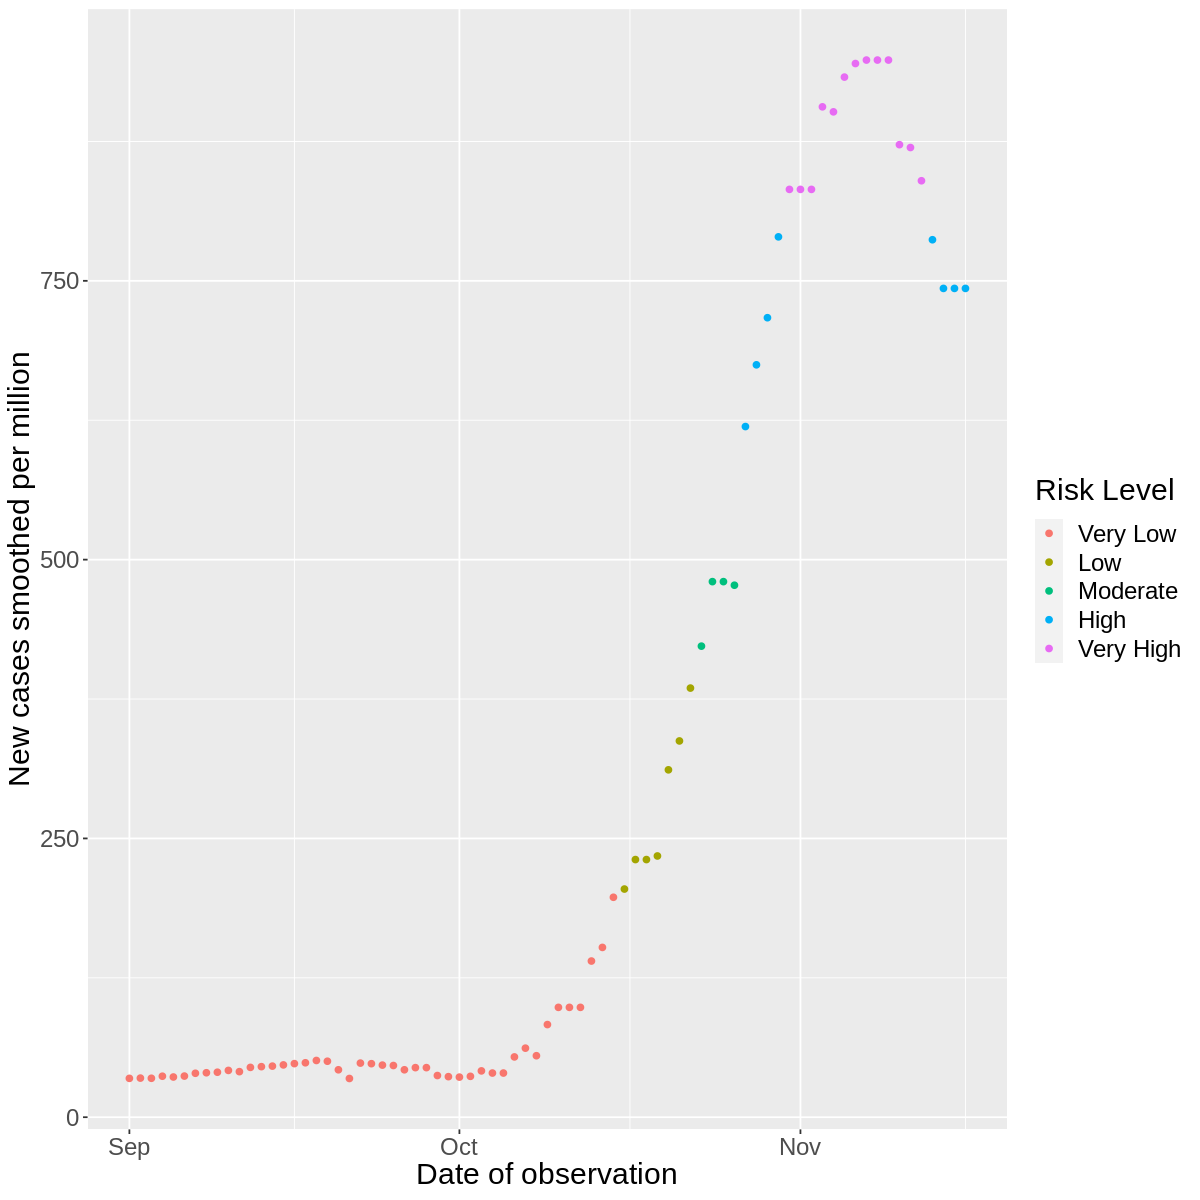

In [6]:
#add options to size plot properly
options(repr.plot.width = 10, repr.plot.height = 10)

# our preliminary exploratory plot - to visualize how risk level changes over time in a given country 
test_plot <- newdata %>%
  filter(location == "Switzerland") %>%
  ggplot(aes(x=date, y=new_cases_smoothed_per_million, colour = risk_level)) + 
  geom_point() + 
  labs(x = "Date of observation", y = "New cases smoothed per million", colour = "Risk Level") +
  theme(text = element_text(size = 18))

#adding figure title
strong("Figure 1: Number of cases smoothed per million vs. date of observation (Switzerland example)")
test_plot

From here, we begin the data analysis/prediction preprocessing. We will split our data into a 75:25 training-testing split. We believe that this is the best possible split as from the previous label counter, we can see that we have ~50 of the 'Very High' risk label, therefore in retaining 1/4 for testing data, we are able to take approximately ~13. 

In [7]:
set.seed(1234) 
#splitting into testing and training data
covid_split <- initial_split(newdata, prop = 0.75, strata = new_cases_per_million)
covid_training <- training(covid_split)
covid_testing <- testing(covid_split)

#counting labels for training data
counts_train <- covid_training %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
strong("Table 5: Label counts for training data") 
head(counts_train)

#counting labels for testing data
counts_test <- covid_testing %>%
  group_by(risk_level) %>%
  summarize(counts=n())

#adding table title
strong("Table 6: Label counts for testing data") 
head(counts_test)

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,7511
Low,505
Moderate,217
High,65
Very High,39


`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

risk_level,counts
<fct>,<int>
Very Low,2523
Low,148
Moderate,62
High,30
Very High,13


 
Before creating our recipe, we must determine which columns within our data set are best suited to act as our predictors. To do this, we can create a scatterplot matrix of all the different predictors we are debating, and subsequently determine their correlation with our predicting variable.


Shiny tags cannot be represented in plain text (need html)

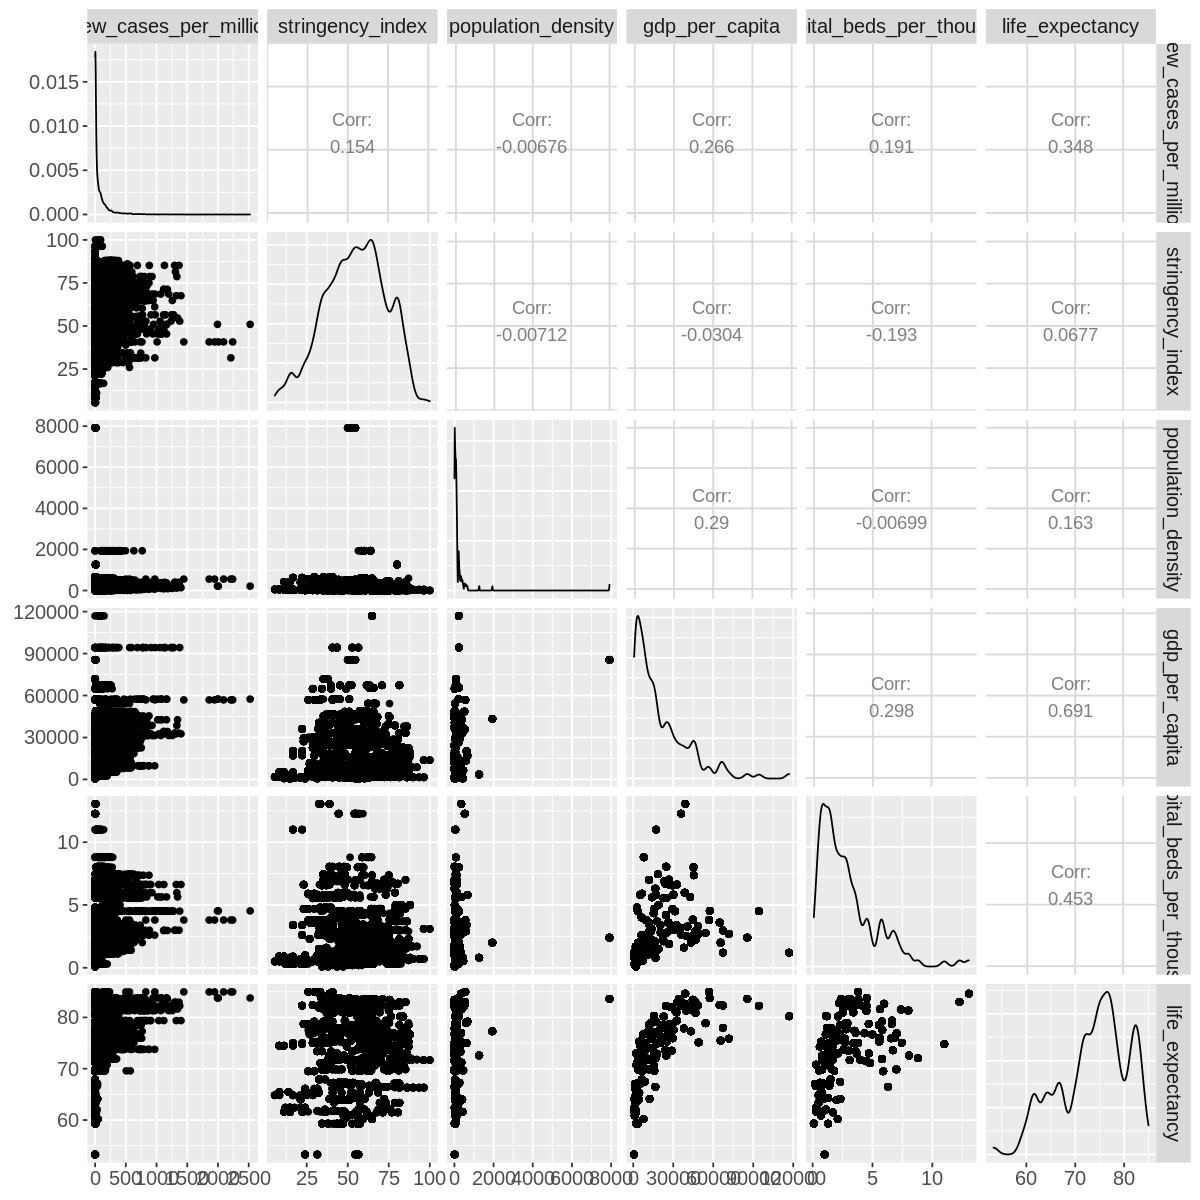

In [8]:
#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#creating a scatterplot matrix through the ggpairs() function
plot_pairs <- newdata %>% 
  select(new_cases_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy) %>% 
  ggpairs() + 
  theme(text = element_text(size = 15))

#adding figure title
strong("Figure 2: Scatterplot matrix for potential predictors")
plot_pairs

Our scatterplot matrix compares many potential predictors; their definitions and significance explained below. Stringency_index refers to the severity of each country's lockdown policies. For example, a higher stringency_index represents a country with extreme social restrictions and regulations, such as China or Vietnam. gdp_per_capita is a measure of a country’s wealth per person (i.e. total market value/population). Finally, life_expectancy refers to the average age that citizens are expected to live.
Most of our predictors have a correlation coefficient of above 0.25, such as gdp_per_capita, hospital_beds_per_thousand, life_expectancy, and stringincy_index. Even though this is not the strongest correlation coefficient, we believe that this combination of predictors will be sufficient to predict within a reasonable margin. However, population_density has a correlation coefficient of around -0.004, which signifies that it is not strongly correlated to new_cases_per_million. Normally, it would be best to continue without this predictor, however, we believe it would be beneficial to keep this predictor due to the fact that it will help the model select values which originate from similar countries.
We chose our 5 predictors: stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy, for several different reasons. We expect each predictor to relate to our target variable (new_cases_per_million) as follows:
- stringency_index will negatively correlate with infection rate, as it refers to government regulations and restrictions aimed to limit COVID-19 spread
- gdp_per_capita will negatively relate to new_cases_per_million, since poorer countries likely have less access to medical care
- hospital_beds_per_thousand will negatively correlate with our predictor, as it may indicate better healthcare
- life_expectancy will negatively correlate with new_cases_per_million, since a country supporting older citizens likely has first-class healthcare 
 
 
Note: Each predictor alone is not enough to predict infection rate as they all depend on and relate to each other. (ie. higher gdp_per_capita relates to higher hosptial_beds_per_thousand). Therefore, it is important to utilize a variety of predictors.

In [9]:
set.seed(1234) 
# selecting relevant predictors
covid_predictors <- covid_training %>%
  select(new_cases_per_million, stringency_index, population_density, gdp_per_capita, hospital_beds_per_thousand, life_expectancy)

# creating a recipe 
recipe <- recipe(new_cases_per_million ~., data = covid_predictors) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#conducting 5-fold cross validation to determine the best parameter for number of neighbors
cross_validation <- vfold_cv(covid_predictors, v = 5, strata = new_cases_per_million)

#knn model specifications for knn-regression while tuning for 'k'
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression")

strong("Table 7: Predictors for our model")
head(covid_predictors)

recipe
knn_tune

Shiny tags cannot be represented in plain text (need html)

new_cases_per_million,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.873,21.3,54.422,1803.987,0.5,64.83
0.231,21.3,54.422,1803.987,0.5,64.83
0.976,21.3,54.422,1803.987,0.5,64.83
1.156,21.3,54.422,1803.987,0.5,64.83
0.411,21.3,54.422,1803.987,0.5,64.83
0.514,21.3,54.422,1803.987,0.5,64.83


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We scaled and centered the predictors since we are utilizing KNN-regression, which calculates Euclidean distance between neighboring points. Furthermore, we will be performing 5-fold cross-validation to determine the optimal ‘k' value, while also minimizing computation time and hardware requirements for the user. 

We now run the recipe/specification through a workflow to calculate the resulting RMSE for 'k' values from 1 to 20. Since the accuracy for larger 'k' values is known to deteriorate, we will calculate the first 20 neighbors as these values will be the most practical for our usage.

In [10]:
set.seed(1234)

#utilizing a workflow in order to determing the RMSE within each value of k 
workflow <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = cross_validation, grid = 20) %>%
    collect_metrics()

#adding table title
strong("Table 8: Metrics from workflow") 
head(workflow)


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice


Warning message:
“package ‘vctrs’ was built under R version 4.0.2”


Shiny tags cannot be represented in plain text (need html)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,118.1746248,5,2.44114865,Preprocessor1_Model01
1,rsq,standard,0.4596444,5,0.03319675,Preprocessor1_Model01
2,rmse,standard,102.7504449,5,4.37861765,Preprocessor1_Model02
2,rsq,standard,0.5609160,5,0.04353141,Preprocessor1_Model02
3,rmse,standard,99.4174642,5,4.29831831,Preprocessor1_Model03
3,rsq,standard,0.5788306,5,0.03230557,Preprocessor1_Model03


We will be determining the optimal 'k' value based on the RMSE by taking the minimum of the RMSE values for all values of 'k'. The RMSE refers to the error of the model’s prediction on the testing data. 

Shiny tags cannot be represented in plain text (need html)

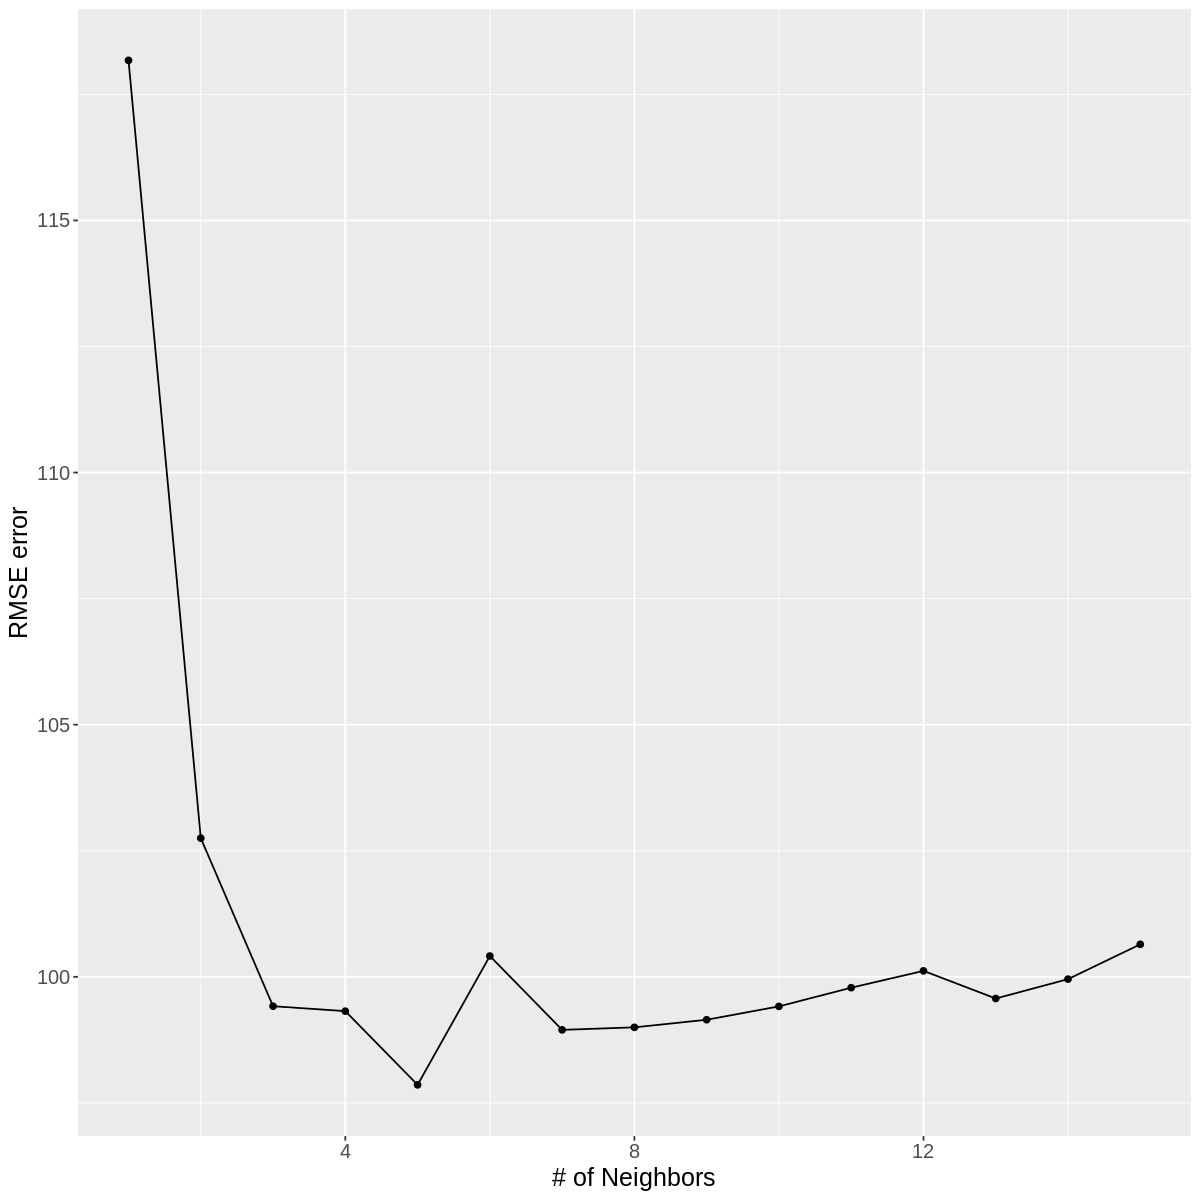

In [11]:
#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#filtering out the smallest value of RMSE to use for k
best_fit <- workflow %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean)) %>%
  pull(neighbors)

#plot of the RMSE against k value
bestk <- workflow %>% 
    filter(.metric == "rmse") %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "# of Neighbors", y = "RMSE error") +
    theme(text = element_text(size = 15))

#adding figure title
strong("Figure 3: RMSE per Neighbor relationship")
bestk

From the plot, we see that the inherent error within different  'k'’s fluctuates. This signifies that our model is sensitive to the number of neighbors that it utilizes, where 5 is the seemingly optimal value, achieving the lowest RMSE.
Now that we have the optimal number of neighbors, we can determine the overall RMSPE of our model by predicting on our testing data. We can do this by creating a new model specification where it utilizes the optimal 'k' value.


In [12]:
#optimized KNN regression specification with optimal 'k' value
optimized_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_fit) %>%
      set_engine("kknn") %>%
      set_mode("regression")

#new workflow with new model specification, fitted to training data
optimized_workflow <- workflow() %>%
  add_model(optimized_knn_spec) %>%
  add_recipe(recipe) %>%
  fit(data = covid_training)

#predicting on testing data
testing_comparison <- optimized_workflow %>%
  predict(covid_testing) %>%
  bind_cols(covid_testing)

#collecting the error within our model 
metrics <- testing_comparison %>%
  metrics(truth = new_cases_per_million, estimate = .pred) 

#adding table title
strong("Table 9: RMSPE for 5 Neighbors") 
head(metrics)

Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,94.8081364
rsq,standard,0.6062277
mae,standard,32.0845840


Our model’s resultant RMSPE is approximately ~95.0, signifying that every prediction made will generally be within +-95.0 cases of the true quantity. With approximately a 200 new_cases_smoothed_per_million difference between each interval, an error value of ~95.0 will not change the label from one to another. At worst, the label may shift one ranking up or down, for example, a prediction of 180 new_cases_per_million with maximum error will result in 275 new_cases_per_million, which is still within the 'Low' boundary instead of ‘Very_Low”.

Since this is the margin of error within our model, it is the generalized largest possible error value within our prediction, therefore, we are able to compare our predictions on the testing data set against their true values.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Shiny tags cannot be represented in plain text (need html)

location,prediction,true_value,error
<chr>,<dbl>,<dbl>,<dbl>
Mexico,29.31052000,38.24505000,8.93453000
Poland,129.59650526,183.33563158,53.73912632
Cambodia,0.02905263,0.01894737,0.01010526
Belarus,22.98425000,41.72912500,18.74487500
Japan,4.31078462,6.76084615,2.45006154
Pakistan,2.52326923,3.35265385,0.82938462
Cape Verde,163.37813636,140.94481818,22.43331818
Sweden,15.07040000,152.39676190,137.32636190
Bulgaria,138.94713333,211.09214286,72.14500952


Using location as id variables



Shiny tags cannot be represented in plain text (need html)

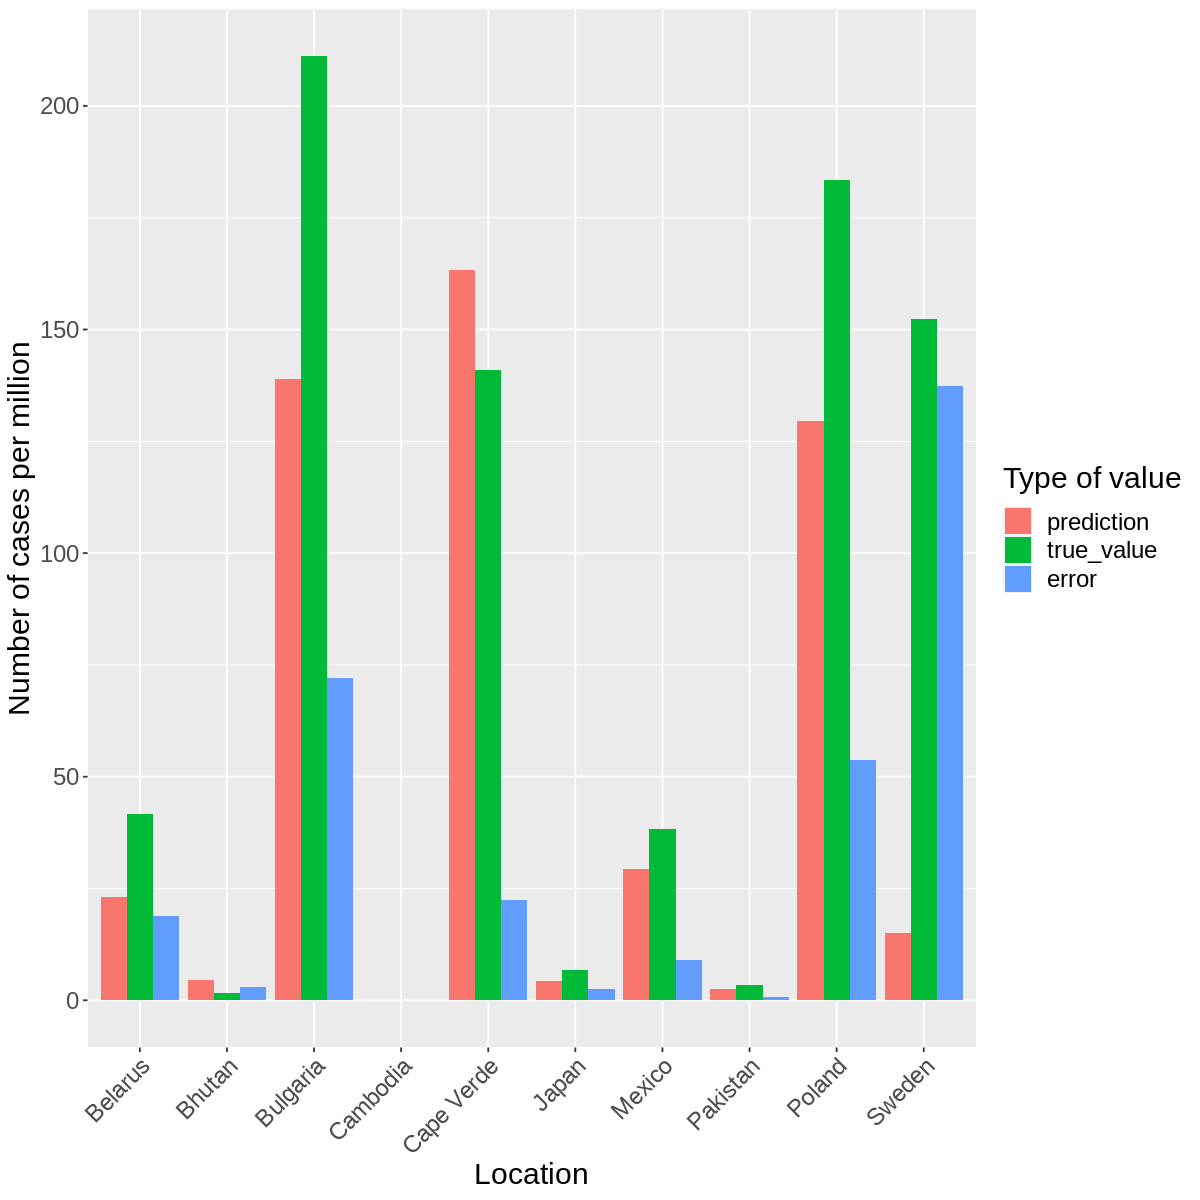

In [13]:
#setting new seed for the sample_n() function
set.seed(1994)

#creating an average prediction per country to compare
mean_prediction_per_country <- testing_comparison %>%
    group_by(location) %>%
    summarize(prediction = mean(.pred))

#creating an average quantity of cases per country to compare
mean_newcases_per_country <- testing_comparison %>%
    group_by(location) %>%
    summarize(true_value = mean(new_cases_per_million)) %>%
    select(-location)

#binding columns in order to visually compare, and taking the difference with a random sample of 10
comparison_table <- bind_cols(mean_prediction_per_country, mean_newcases_per_country) %>%
  mutate(error = abs(true_value - prediction)) %>%
  sample_n(10)

#adding table title
strong("Table 10: Comparing mean prediction value against mean true value")   
comparison_table

#options to resize plot into a readable size
options(repr.plot.width = 10, repr.plot.height = 10)

#bar graph of prediction against true value
comparison_table_bar <- comparison_table %>%
  melt() %>%
  ggplot(aes(x = location, y = value, fill = variable)) + 
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Location", y = "Number of cases per million", fill = "Type of value") + 
  theme(text = element_text(size = 18), axis.text.x = element_text(angle = 45, hjust = 1))

#adding figure title
strong("Figure 4: Quantifying true values against predicted value and corresponding error")
comparison_table_bar

We can compare the true_value of the average new_cases_per_million of a given country along with its corresponding prediction for the same country. Though our model holds an RMSPE value of around +-95.0, when taking a random sample of 10 rows, it is evident that most of the predictions lie within a far smaller margin than 95.0 cases. However, we can not ignore the difference of Sweden which is around ~137.0 cases. Since the RMSPE is the generalized error within the model, and we can see that 9 of the 10 values lie within the margin, the error for Sweden represents a rare set of values which lie slightly outside of the RMSPE range. We can conclude that our model has an RMSPE of ~95.0, however, most of its predictions fall well within that error margin, and thus we can predict with relatively high accuracy.	
 
 
With all of these preliminary steps out of the way, we can predict the new_cases_per_million of each of the five countries Billy wishes to move to: Austria, Switzerland, Japan, Denmark, and the United Arab Emirates. The current date is November 16th, 2020, but Billy wishes to predict the values today such that he is able to book his flight for tomorrow, therefore, Billy needs to search for the relevant predictor information online to successfully inform his decision. After searching online, he constructs a tibble with all of the relevant observations needed for his prediction.

In [14]:
# observations for November 17th, 2020, of Austria, Switzerland, Japan, Denmark, United Arab Emirates
new_obs_austria <- tibble(location = "Austria", stringency_index = 75, population_density = 106.749, gdp_per_capita = 45436.69, hospital_beds_per_thousand = 7.37, life_expectancy = 81.54)
new_obs_switzerland <- tibble(location = "Switzerland", stringency_index = 50.93, population_density = 214.243, gdp_per_capita = 57410.17, hospital_beds_per_thousand = 4.53, life_expectancy = 83.78)
new_obs_japan <- tibble(location = "Japan", stringency_index = 38.89, population_density = 347.778, gdp_per_capita = 39002.22, hospital_beds_per_thousand = 13.05, life_expectancy = 84.63)
new_obs_Denmark <- tibble(location = "Denmark", stringency_index = 54.63, population_density = 136.52, gdp_per_capita = 46682.51, hospital_beds_per_thousand = 2.5, life_expectancy = 80.9)
new_obs_United_arab_emirates <- tibble(location = "United Arab Emirates", stringency_index = 45.37, population_density = 112.442, gdp_per_capita = 67293.48, hospital_beds_per_thousand = 1.2, life_expectancy = 77.97)

new_obs_all <- rbind(new_obs_austria, new_obs_switzerland, new_obs_japan, new_obs_Denmark, new_obs_United_arab_emirates)

#adding table title
strong("Table 11: Billy's desired country observations") 
new_obs_all

Shiny tags cannot be represented in plain text (need html)

location,stringency_index,population_density,gdp_per_capita,hospital_beds_per_thousand,life_expectancy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,75.00,106.749,45436.69,7.37,81.54
Switzerland,50.93,214.243,57410.17,4.53,83.78
Japan,38.89,347.778,39002.22,13.05,84.63
Denmark,54.63,136.520,46682.51,2.50,80.90
United Arab Emirates,45.37,112.442,67293.48,1.20,77.97


Now that Billy has all of his predictors, he is able to run them through the created model and return his final results. Additionally, the labels will be added to the final predictions in order to qualitatively compare the predicted risk_level of each country Billy wishes to visit against the overall state of the world.

Shiny tags cannot be represented in plain text (need html)

location,.pred,prediction_risk_level
<chr>,<dbl>,<fct>
Japan,4.4166,Very Low
United Arab Emirates,87.4384,Very Low
Denmark,138.6348,Very Low
Austria,566.3974,Moderate
Switzerland,1110.9214,Very High


Shiny tags cannot be represented in plain text (need html)

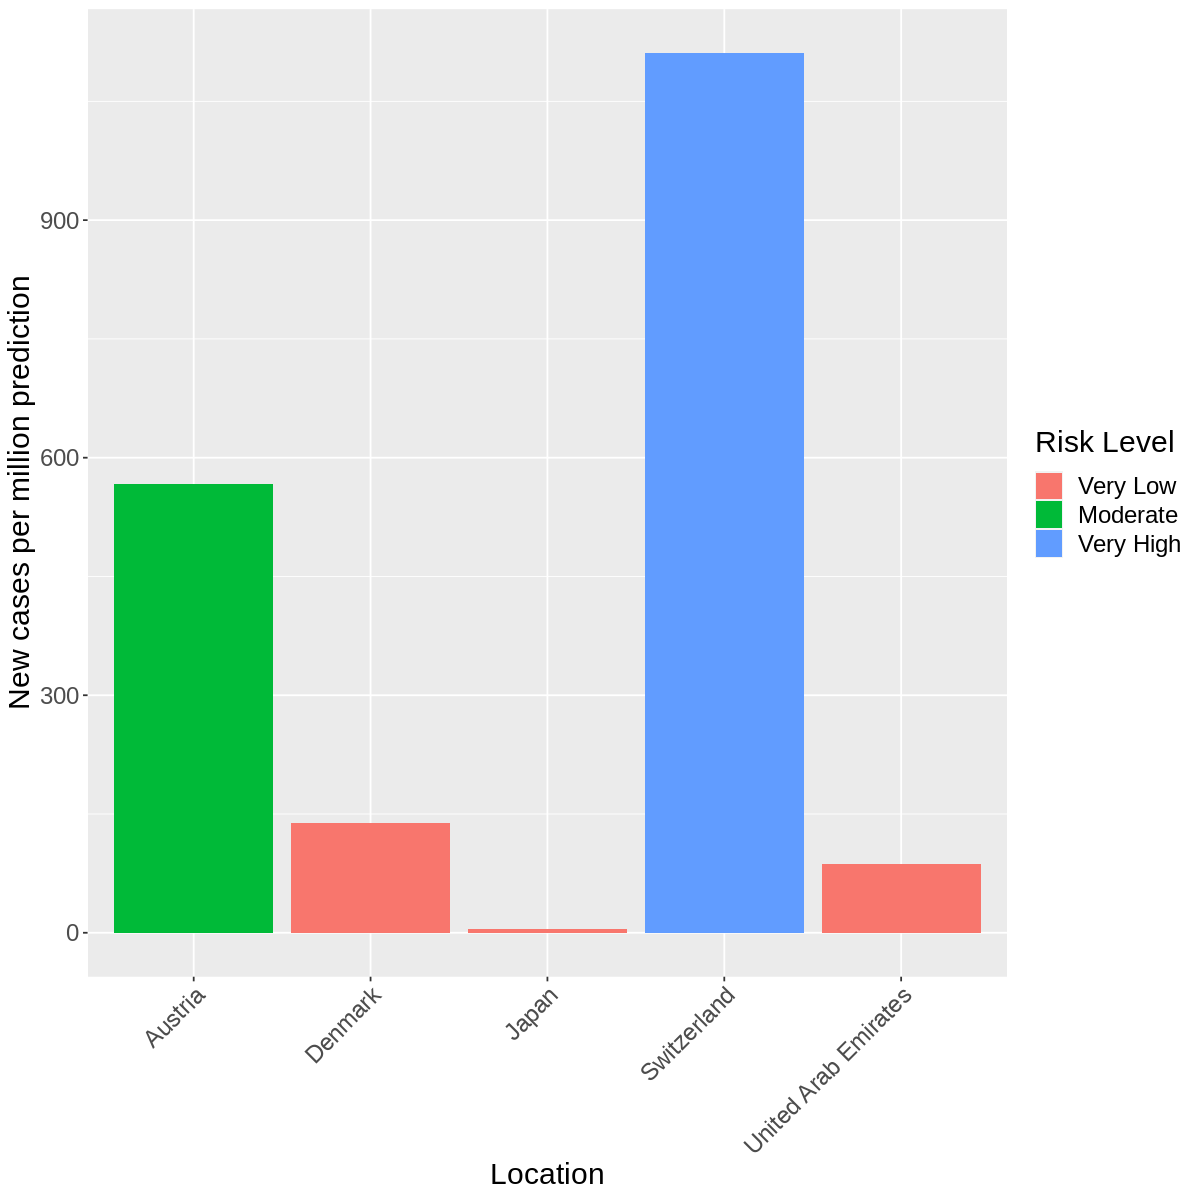

In [15]:
#final predictions for Billy
final_predictions <- optimized_workflow %>%
  predict(new_obs_all) %>%
    bind_cols(new_obs_all) %>%
    select(location, .pred) %>%
    arrange(.pred)

#adding back the labels from prior in order to qualitatively determine the risk of each location
prediction_risk_level <- final_predictions$.pred %>%
  cut(breaks = c(0,198,395,593,790,1200), labels = c("Very Low", "Low", "Moderate", "High", "Very High"))

final_predictions$prediction_risk_level <- prediction_risk_level

#adding table title
strong("Table 12: Final results for Billy's chosen countries") 
final_predictions

#bar graph of prediction against true value
final_predictions_bar <- final_predictions %>%
  ggplot(aes(x = location, y = .pred, fill = prediction_risk_level)) + 
  geom_bar(stat = "identity") +
  labs(x = "Location", y = "New cases per million prediction", fill = "Risk Level") + 
  theme(text = element_text(size = 18), axis.text.x = element_text(angle = 45, hjust = 1))

#adding figure title
strong("Figure 5: Visualizing Billy's predictions with risk level")
final_predictions_bar

The results are in, and Billy has booked his plane ticket to Japan. We can see that Japan is predicted to have the lowest new_cases_per_million on November 17th, 2020, therefore deeming it a worthy candidate for Billy to go and find a job. Billy is confident that he will be able to find work in Japan  as its economy may be less impacted by the virus, as infection rates in Japan are very low in comparison to locations such as Switzerland. Furthermore, although the labels predict that Japan, United Arab Emirates, and Denmark are all classified as 'Very Low', we can see that Japan has way fewer predicted new cases, thus making it a no brainer for Billy. There is one issue though, Billy spent so much time tinkering with this model that he has forgotten to open up his Japanese dictionary, so he will be in for a treat upon asking for directions at the airport.

**Discussion**

Using new observations from five countries of Billy’s interest, our model predicted that Japan has the lowest number of new_cases_per_million while falling within the ‘Very Low’ risk-level category. This suggests that it is relatively safe for Billy to move to Japan. Given the low number of cases in Japan over the past few months (Ritchie 2020), the low number of COVID-related deaths (Wingfield-Hayes, 2020), and the high quantity of hospital beds per thousand, this might be expected. However, a very recent surge in COVID-19 cases in Japan (Takashi 2020) could threaten this prediction if this outbreak is not controlled in the future. It would therefore be an interesting future question to predict the upcoming trajectory of cases, instead of simply case numbers, for a more accurate risk assessment and for the future of our buddy Billy.

**References**

Ritchie, H. (2020) Coronavirus Source Data [Data set]. OWID - University of Oxford. https://ourworldindata.org/coronavirus-source-data

Wingfield-Hayes, R. (2020). Coronavirus: Japan’s mysteriously low virus death rate. BBC News. https://www.bbc.com/news/world-asia-53188847

Takahasi, R. (November 18, 2020). Tokyo to raise alert as Japan sets daily record with 2000-plus COVID-19 cases. The Japan Times. https://www.japantimes.co.jp/news/2020/11/18/national/tokyo-coronavirus-alert-level